# T2 - Fourier Methods

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

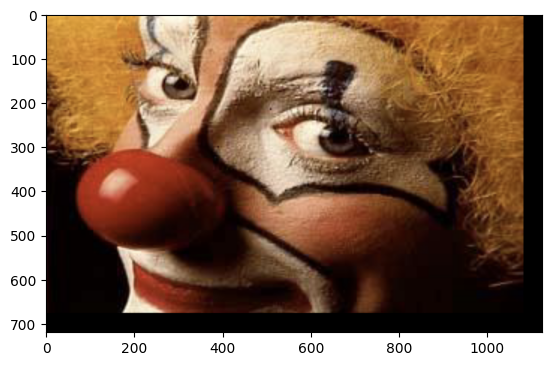

In [54]:
img = cv2.imread('image.png')

def img_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    float32_img = np.float32(img / 255.0)

    h, w, c = float32_img.shape

    optimal_rows = cv2.getOptimalDFTSize(h)
    optimal_cols = cv2.getOptimalDFTSize(w)
    padded_img = cv2.copyMakeBorder(float32_img, 
                            0, optimal_rows - h,
                            0, optimal_cols - w,
                            cv2.BORDER_CONSTANT, value=0)
    return padded_img

img = img_preprocess(img)
plt.axis('off')
_ = plt.imshow(img)

In [64]:
def dft(ch):
    # Perform DFT
    dft = cv2.dft(ch, flags=cv2.DFT_COMPLEX_OUTPUT)
    # Shift DFT to center
    dft_shift = np.fft.fftshift(dft)
    # Return [R, I]
    return dft_shift

# HxWx3 -> 3x(HxWx2)
dft_img = np.array([dft(img[:,:,i]) for i in range(img.shape[2])])

(3, 720, 1125)
(720, 1125)


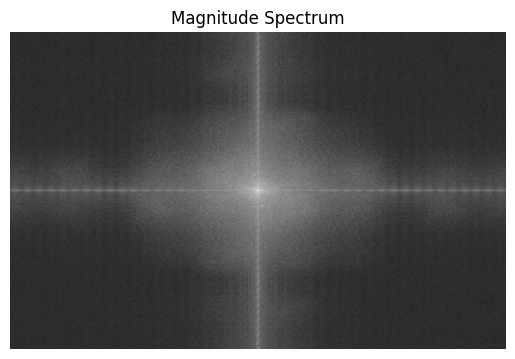

In [151]:
def dft_img_calc_magitude(dft_img):
    return np.array(
        [
            cv2.magnitude(dft_img[i,:,:,0], dft_img[i,:,:,1])
            for i in range(dft_img.shape[0])
        ])

def sum_magnitude(magitude_img):
    return np.sum(np.log(magitude_img), axis=0)

magitude_img = dft_img_calc_magitude(dft_img)
print(magitude_img.shape)
magnitude_spectrum = sum_magnitude(magitude_img)
print(magnitude_spectrum.shape)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


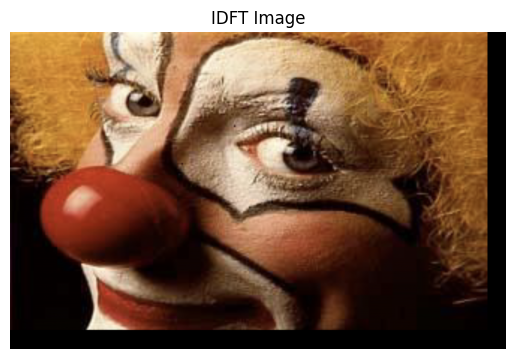

In [117]:
def idft(ch):
    # Shift DFT to normal
    dft = np.fft.ifftshift(ch)
    # Perform IDFT
    idft = cv2.idft(dft, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    return idft

def dft_img_idf(dft_img):
    """ -> 3 x H x W -> H x W x 3"""
    idf = np.array([idft(dft_img[i]) for i in range(dft_img.shape[0])])
    return np.moveaxis(idf, 0, -1)

idf_img = dft_img_idf(dft_img)
plt.imshow(idf_img)
plt.title('IDFT Image')
plt.axis('off')
plt.show()

In [81]:
def viz_three_img(orig, dft, idft):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(orig)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(dft, cmap='gray')
    axs[1].set_title('DFT Image')
    axs[1].axis('off')
    axs[2].imshow(idft)
    axs[2].set_title('IDFT Image')
    axs[2].axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


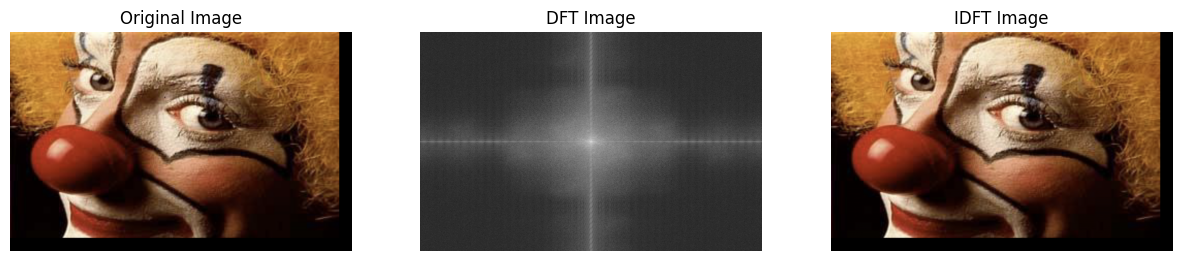

In [82]:
viz_three_img(img, magnitude_spectrum, idf_img)

In [163]:
def create_low_pass_filter(width, height, cutoff_frequency):
    rows, cols = np.mgrid[0:height, 0:width]
    center_x, center_y = width // 2, height // 2
    radius = np.sqrt((rows - center_y)**2 + (cols - center_x)**2)
    radius = radius / radius.max()
    mask = radius <= cutoff_frequency
    return mask

def apply_low_pass_filter(idf_image, cutoff_frequency=0.2):
    channels, height, width, complex_dim = idf_image.shape
    assert complex_dim == 2, "Expected complex number representation (real, imaginary)"
    filter_mask = create_low_pass_filter(width, height, cutoff_frequency)
    filtered_image = np.zeros_like(idf_image)
    

    for c in range(channels):
        complex_channel = idf_image[c, :, :, 0] + 1j * idf_image[c, :, :, 1]
        # true -> 1, false -> max
        filter_mask = filter_mask.astype(np.float32)
        # Apply filter
        filtered_channel = complex_channel * filter_mask
        filtered_channel += 1 - filter_mask
        
        # Store real and imaginary parts
        filtered_image[c, :, :, 0] = np.real(filtered_channel)
        filtered_image[c, :, :, 1] = np.imag(filtered_channel)
    
    return filtered_image

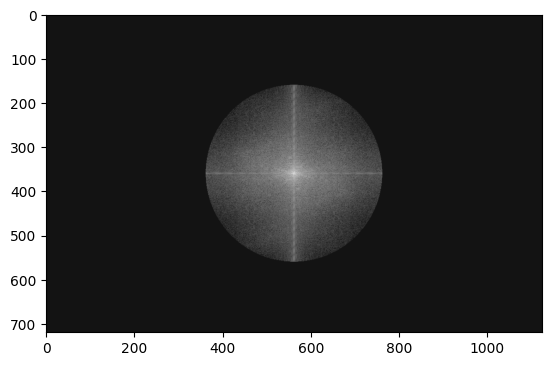

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


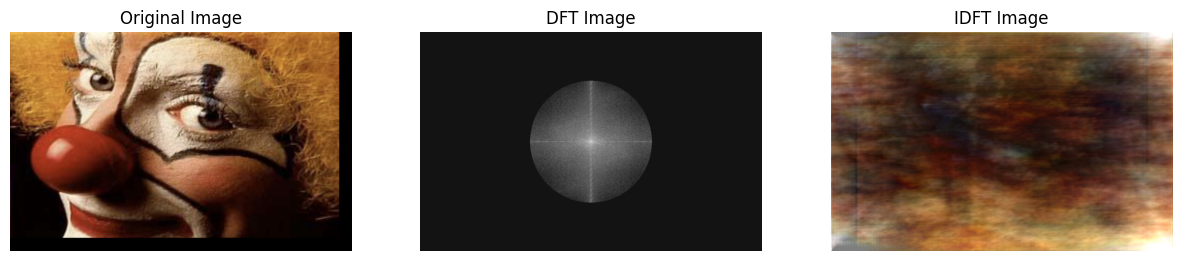

In [165]:
# dft is 3 x H x W x 2
dft_img_low = apply_low_pass_filter(dft_img, cutoff_frequency=0.3)
mag_low = dft_img_calc_magitude(dft_img_low)
sum_mag_low = sum_magnitude(mag_low)
plt.imshow(sum_mag_low, cmap='gray')
plt.show()

low_img = dft_img_idf(mag_low)
viz_three_img(img, sum_mag_low, low_img)